##### Quantum Data Science 2021/2022
## Lecture 6 - Variational Machine Learning

*Machine Learning with quantum computers -  Section 5.1.3*

## Contents

1. [Important functions](#important)
2. [Hello world - qubit rotation](#qubit_rotation)
4. [Single-qubit binary classification](#binary_classification)

### 1. Important functions
<a id="important"></a>

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [81]:
### EXECUTE CIRCUIT ###
def execute_circuit(qc, shots=1024, device=None, decimal=False):
    if device is None:
        device = Aer.get_backend('qasm_simulator')
    else:
        device = device
    
    #circ_trans = transpile(qc,device)
    counts = device.run(qc, shots=shots).result().get_counts()
    
    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

### BASIS STATES PROBABILITIES ###
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


### 2. Hello world - qubit rotation 
<a id="qubit_rotation"></a>

##### Goal: Find a model that maps the state $|0\rangle$ to the state $|1\rangle$

<p align="center">
  <img width="600" height="500" src="images/rotation.jpeg">
</p>

Let $\langle \sigma_z \rangle_{\theta}$ be the expectation value of the computational basis measurement, that now depends on the variational parameter $\theta$.

$$ \langle \sigma_z \rangle_{\theta} = \langle \psi(\theta)|\sigma_z|\psi(\theta)\rangle = \langle0| R_y(\theta)^{\dagger} \sigma_z R_y(\theta)|0\rangle$$

Remember that $\langle \sigma_z \rangle_{\theta} \in [-1,1]$ , and we wanto to obtain $\langle \sigma_z \rangle_{\theta} = -1$. Thus $\langle \sigma_z \rangle_{\theta}$ is the cost function that we want to minimize !

The well known gradient based update rule becomes:

$$ \theta \leftarrow \theta - \eta \nabla \langle \sigma_z \rangle_{\theta} $$

In [4]:
## import parameter binding functions
from qiskit.circuit import Parameter,ParameterVector

#### Building blocks

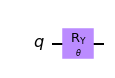

In [45]:
def Embedding(x=None):
    if x is not None:
        ### TO DO ###
        pass

    return QuantumCircuit(1,name="S")

def Ansatz(theta):

    qc = QuantumCircuit(1,name="U($\theta$)")
    qc.ry(theta,0)

    return qc

p = Parameter(r'$\theta$')
qc = Embedding().compose(Ansatz(p))
qc.draw(output="mpl")

In [37]:
def variational_circuit(x,p):
    qc = Embedding(x).compose(Ansatz(p))
    return qc

In [38]:
#single qubit expectation value for Z measurement (lecture 2 - expectation values)
def single_qubit_sigma_z_expval(qc,n_qubits=1):    

    qc.measure_all()
    counts = execute_circuit(qc,shots=1024,decimal=True)
    probs = basis_states_probs(counts, shots=1024, n_qubits=n_qubits,decimal=True)
    
    return probs[0] - probs[1]

#Cost function is simply the expectation value that we want to minimize
def cost_function(x,p):

    qc = variational_circuit(x,p)
    expval_z = single_qubit_sigma_z_expval(qc,n_qubits=1)

    return expval_z

Test if the cost function is working:

In [48]:
p = np.random.random(1)
x = None
c = cost_function(x,p)
print("cost for theta={} ----> {}".format(p,c))


cost for theta=[0.05786336] ----> 1.0


In [49]:
from qiskit.algorithms.optimizers import COBYLA, ADAM, SPSA #...

# Callback function for optimiser for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

parameters = []
costs = []
evaluations = []

optimizer = SPSA(maxiter=50,callback=store_intermediate_result)

p = np.random.random(1)
x = None

objective_function = lambda p: cost_function(x,p)
                                              
ret = optimizer.optimize(num_vars=1, objective_function=objective_function, initial_point=p)

print("OPTIMIZATION COMPLETED! RESULT ---> {}".format(ret))


OPTIMIZATION COMPLETED! RESULT ---> (array([3.14476285]), -1.0, 150)


#### Plot the cost function

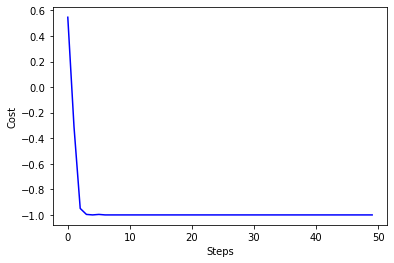

In [50]:
fig = plt.figure()
plt.plot(costs,color='blue')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

#### <span style="color: red;">EXERCISE 1:</span> Let's try an ansatz with a more general single-qubit gate!

Remember that the most general gate is decomposed by 3 angles $(\theta,\phi,\beta)$:

$$ U(\theta,\phi,\beta) = R_z(\theta)R_y(\phi)R_z(\beta) $$

aka U3 gate in qiskit 

/var/folders/n9/tdqdt7991733xw39nzh49y600000gn/T/ipykernel_40736/1740059434.py:15: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(*params,0)


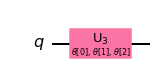

In [54]:
def Embedding(x=None):
    if x is not None:
        ### TO DO ###
        pass

    return QuantumCircuit(1,name="S")

def Ansatz(params):

    qc = QuantumCircuit(1,name="U($\theta$)")
    qc.u3(*params,0)
    return qc

p = ParameterVector(r'$\theta$',3)
qc = Embedding().compose(Ansatz(p))
qc.draw(output="mpl")

In [55]:
parameters2 = []
costs2 = []
evaluations2 = []

def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations2.append(evaluation)
    parameters2.append(parameter)
    costs2.append(cost)

optimizer = SPSA(maxiter=100,callback=store_intermediate_result)

p = np.random.random(3)
x = None

objective_function = lambda p: cost_function(x,p)
                                              
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=p)

print("OPTIMIZATION COMPLETED! RESULT ---> {}".format(ret))


/var/folders/n9/tdqdt7991733xw39nzh49y600000gn/T/ipykernel_40736/1740059434.py:15: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(*params,0)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


OPTIMIZATION COMPLETED! RESULT ---> (array([ 3.13684492, -1.13373259,  2.06966292]), -1.0, 300)


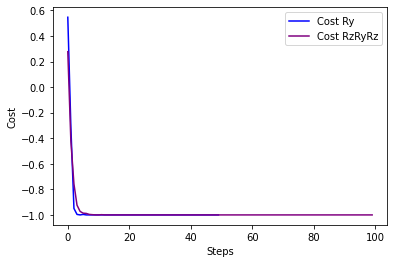

In [56]:
fig = plt.figure()
plt.plot(costs,color='blue',label='Cost Ry')
plt.plot(costs2,color='purple',label='Cost RzRyRz')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

#### Notice the difference in training between the single gate and general single-qubit ansatz ? 

#### <span style="color: red;">EXERCISE 2:</span> Single-qubit binary classification

Consider the problem of **binary classification** - You have a labelled dataset $D = \{ (x_1,y_1) , \dots , (x_N,y_N)\}$ where $x$ corresponds to a point and $y$ to the respective label. As the name suggests, in binary classification $y$ takes only two values. For instance, suppose that points $x$ are images of cats vs dogs. In this case, $y$ corresponds to the label "cat" or "dog". Mathematically speaking we could use "cat" $\mapsto 0$ and "dog" $\mapsto 1$.

Consider now a dataset of single qubit quantum states $D = \{ (x_1,y_1) , \dots , (x_N,y_N)\}$ where $x$ corresponds to a quantum state and $y$ to the label. $0$ in the case of the state being closer to state $|0\rangle$ and $1$ if the state is closer to state $|1\rangle$.

<p align="center">
  <img width="500" height="400" src="images/bin_quantum.jpeg"> 
</p>

Load datasets from file q_dataset.npy
    
    - d is the dataset with quantum state vector and labels [((a_1, b_1), label1) , ...]
    - d_bloch is the dataset with bloch vector representations to plot in the bloch sphere [((x_1, y_1, z_1), label1) , ...] 
    - d_ is the unlabelled dataset with only quantum state vectos [((a_1, b_1)]
    - d__bloch is the unlabelled dataset with bloch vector representations to plot in the bloch sphere [(x_1, y_1, z_1) , ...]

In [176]:
with open("q_dataset.npy", 'rb') as f:
    d = np.load(f, allow_pickle=True)
    d_bloch = np.load(f, allow_pickle=True)    
    d_ = np.load(f, allow_pickle=True)
    d__bloch = np.load(f, allow_pickle=True)

'\nfor i in range(len(d)):\n    if d[i][1] == 0:\n        d[i][1] = -1\n'

Plot the data i.e., plot the single-qubit quantum states in the bloch sphere to understand your data. Use **d_bloch**

In [115]:
from kaleidoscope import bloch_sphere

vec = []
colors = []

for i in d_bloch:
    if i[1]:
        colors.append("#AA00FF")
    else:
        colors.append("#AA00F")

    vec.append(i[0])

for i in d__bloch:
    colors.append("#00FF00")
    vec.append(i)

bloch_sphere(points=vec, points_color=colors)


In [ ]:
def Embedding(x=None):
    
    qc = QuantumCircuit(1,name="S")
    #
    return qc

def Ansatz(params):

    qc = QuantumCircuit(1,name="U($\theta$)")
    #
    return qc

p = ParameterVector(r'$\theta$',3)
qc = Embedding(2).compose(Ansatz(p))
qc.draw(output="mpl")

In [265]:
def variational_circuit(x,p):

    return qc

In [266]:
def classify(prediction):
    
    return 0

In [267]:
def loss_function(x,y,p):
    loss = 0
    
    return loss


In [268]:
def cost_function(D,p):
    cost = 0
    
    return cost

##### Test if the cost function is working properly

In [272]:

p = np.random.random(3)*2*np.pi
D = d
c = cost_function(D,p)
print("cost for theta={} ----> {}".format(p,c))

cost for theta=[3.88310368 3.45244728 2.29306632] ----> 1.0


In [280]:
parameters2 = []
costs2 = []
evaluations2 = []

def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations2.append(evaluation)
    parameters2.append(parameter)
    costs2.append(cost)

optimizer = COBYLA(maxiter=1000000, callback=store_intermediate_result)
D = d

objective_function = lambda p: cost_function(D,p)
                                              
ret = optimizer.optimize(3,objective_function=objective_function, initial_point=p)
#ret = optimizer.minimize(fun=objective_function, initial_point=p)

print("OPTIMIZATION COMPLETED! RESULT ---> {}".format(ret))

/opt/homebrew/Caskroom/miniforge/base/envs/quantum_DS/lib/python3.10/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning:

Method cobyla does not support callback.



OPTIMIZATION COMPLETED! RESULT ---> (array([3.88310368, 5.45244728, 2.29306632]), 0.0, 22)


#### <span style="color: red;">EXERCISE 3:</span> Compare the variational quantum circuit with the swap test circuit. Compare the performance of both algorithms in terms of classification, number of gates used, number of executions of of the quantum circuit etc 